# Projet 4 : Anticipez les besoins energetiques d'une ville
## Missions : 
    * A l'aide de données déjà repertoriées, prédire les émissions de CO2 et la consommation totale d'energie de batiments non destiné à l'habitation
    * Chercher à évaluer la pertinence de l'ENERGY STAR Score pour la prédiction d'emission
    * Pour ce faire :
        ** Realiser une courte analyse exploratoire :
            *** Cleaning des données
            *** Filtration et selection des features
            *** Faire attention à la fuite de données 
        ** Pour chacun des deux modèles à fournir réaliser : 
            *** Une comparaison des différentes méthodes de modélisation de regression (linéaire, à noyau, regression ridge, svm,..)
            *** Analyse des performances (validation croisée,optimisaiotn des hyperparamètres, ROC, PR,..)
            *** Réaliser une selection finale du meilleur modèle

## Cleaning des données


### Format des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [2]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

<AxesSubplot:>

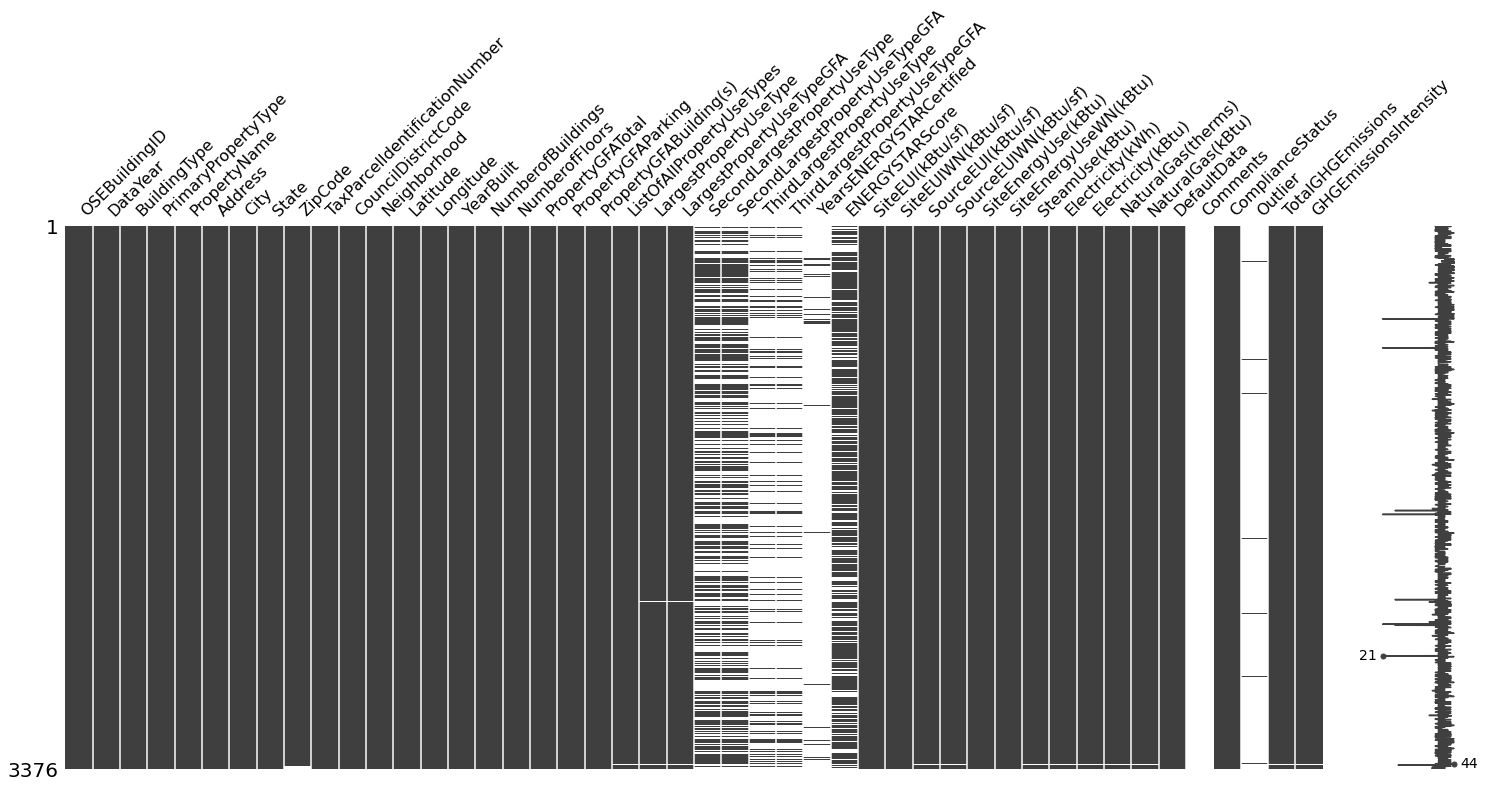

In [4]:
#data type seems ok
msno.matrix(df)

In [5]:
#data is mostly full
data = df

print(data['BuildingType'].unique())

#we'll keep only the nonresidential and educationnal building
non_res = ['NonResidential','Nonresidential COS', 'SPS-District K-12', 'Campus','Nonresidential WA']
data = data.loc[data['BuildingType'].isin(non_res)]

#we'll keep kBtu/square foot for all units
data = data.drop(labels = ['Electricity(kWh)', 'NaturalGas(therms)'], axis = 1)

#drop property name, city, state, taxparcel ID and adress (we have gps coordinates) as it is not useful for the model
data = data.drop(labels = ['PropertyName', 'City', 'State', 'Comments', 
                           'Address', 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified'], axis = 1)

#drop data year as it is only in 2016
data = data.drop(labels = 'DataYear', axis = 1)



#set building id as index
data = data.set_index('OSEBuildingID')

['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [6]:
#check for duplicate
x = data.shape[0]
data = data.drop_duplicates()
print('{} rows were droped.'.format(x-data.shape[0]))

0 rows were droped.


In [7]:
#check for building with 0 energy consumption and/or 0 GHG emission
x = data.shape[0]
data = data.drop(data.loc[data['SiteEnergyUse(kBtu)'] ==0].index)
print('{} rows had no energy consumption and were droped.'.format(x-data.shape[0]))
x=data.shape[0]
data = data.drop(data.loc[data['TotalGHGEmissions'] ==0].index)
print('{} rows had no GHG emission and were droped'.format(x - data.shape[0]))



16 rows had no energy consumption and were droped.
1 rows had no GHG emission and were droped


In [8]:
print(len(data['ComplianceStatus'].unique()))
print(data['ComplianceStatus'].unique())
# have to look into default Data

print(data.loc[data['DefaultData'] == True].shape)
#leave it for now

3
['Compliant' 'Error - Correct Default Data' 'Non-Compliant']
(87, 35)


In [9]:
#look for outlier
print(data['Outlier'].unique())
print(data.loc[data['Outlier'] == 'High outlier'].shape, data.loc[data['Outlier'] == 'Low outlier'].shape)
x = data.shape[0]
#Probleme with the models with the high outliers
data = data.drop(data.loc[data['Outlier'] == 'High outlier'].index)
data = data.drop(data.loc[data['Outlier'] == 'Low outlier'].index)
print('{} rows were dropped.'.format(x-data.shape[0]))

[nan 'High outlier' 'Low outlier']
(2, 35) (15, 35)
17 rows were dropped.


In [38]:
data.loc[data['SiteEnergyUse(kBtu)'] == data['SiteEnergyUse(kBtu)'].max()]

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
49967,Campus,University,98105.0,4,NORTHEAST,47.65644,-122.31041,1900,111.0,0,...,93.800003,873923712.0,0.0,84985240.0,0.0,False,Compliant,NaN,11140.56,1.2


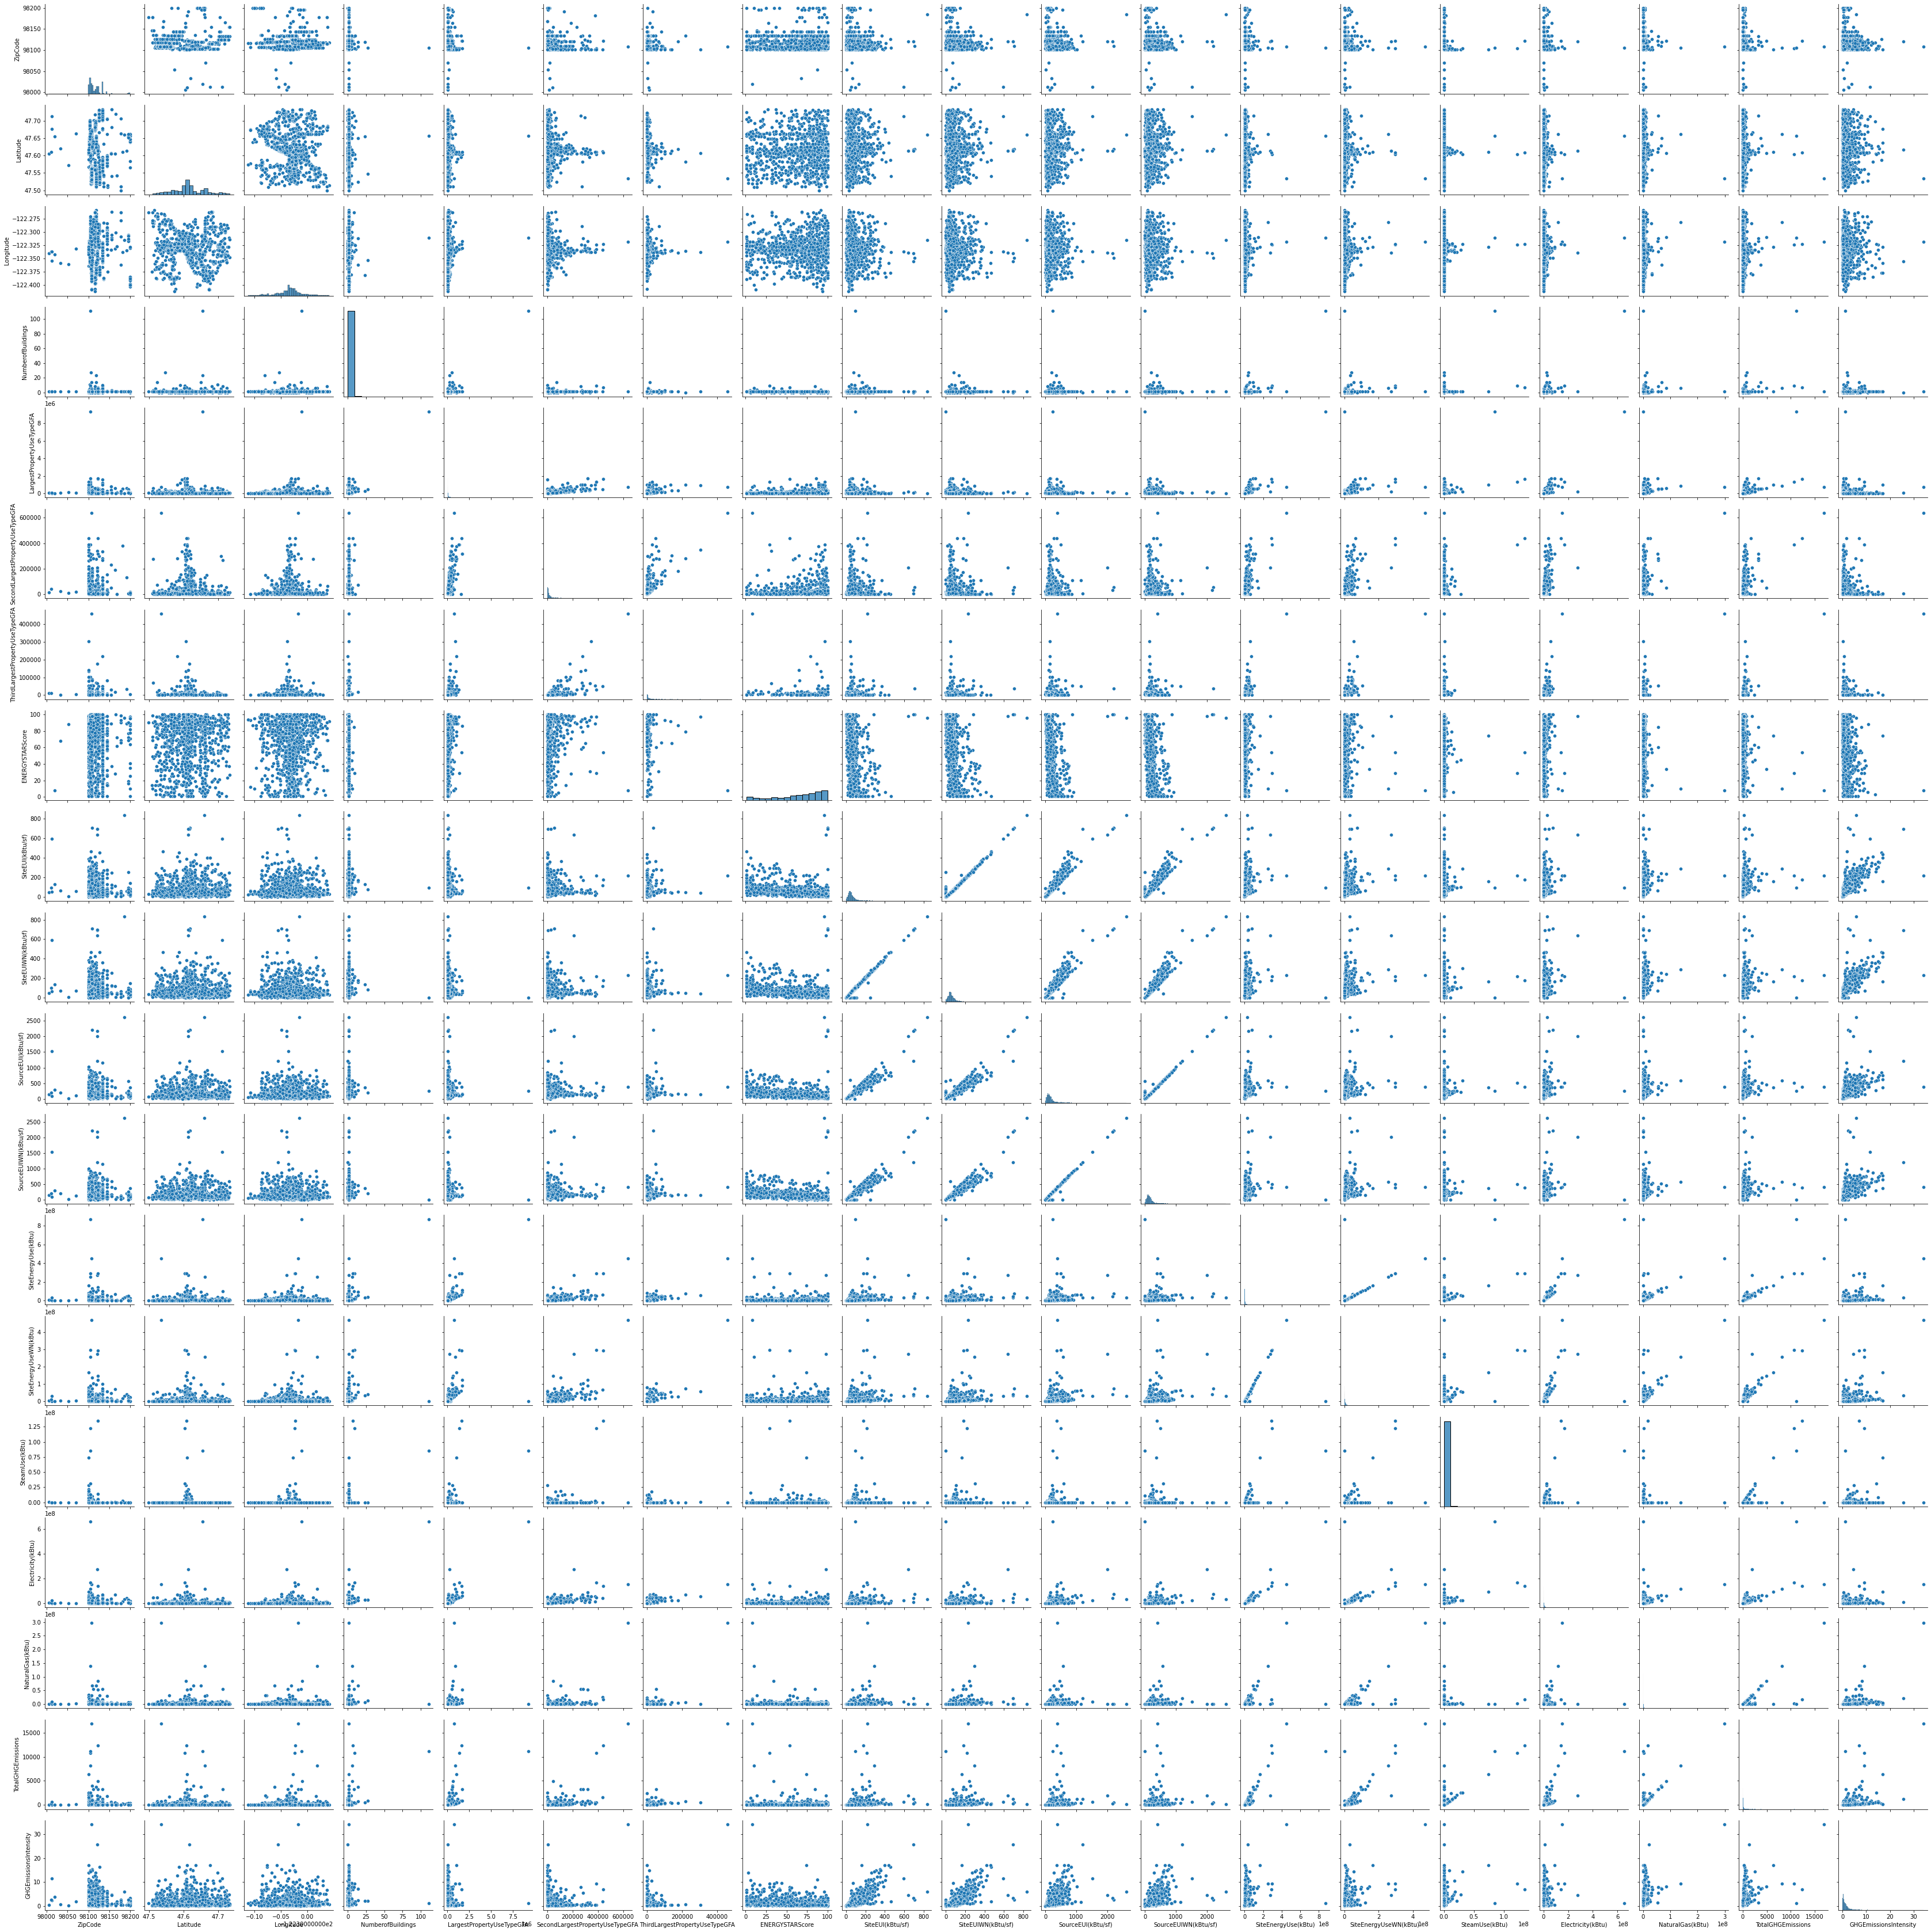

<Figure size 432x288 with 0 Axes>

In [11]:
#Look for colinear features first with numerical values
num_col = []
for i in data.columns:
    if data[i].dtype =='float64':
        num_col.append(i)
data_num = data[num_col]

#do a scatter matrix
sns.pairplot(data=data_num)
plt.show()
plt.clf()

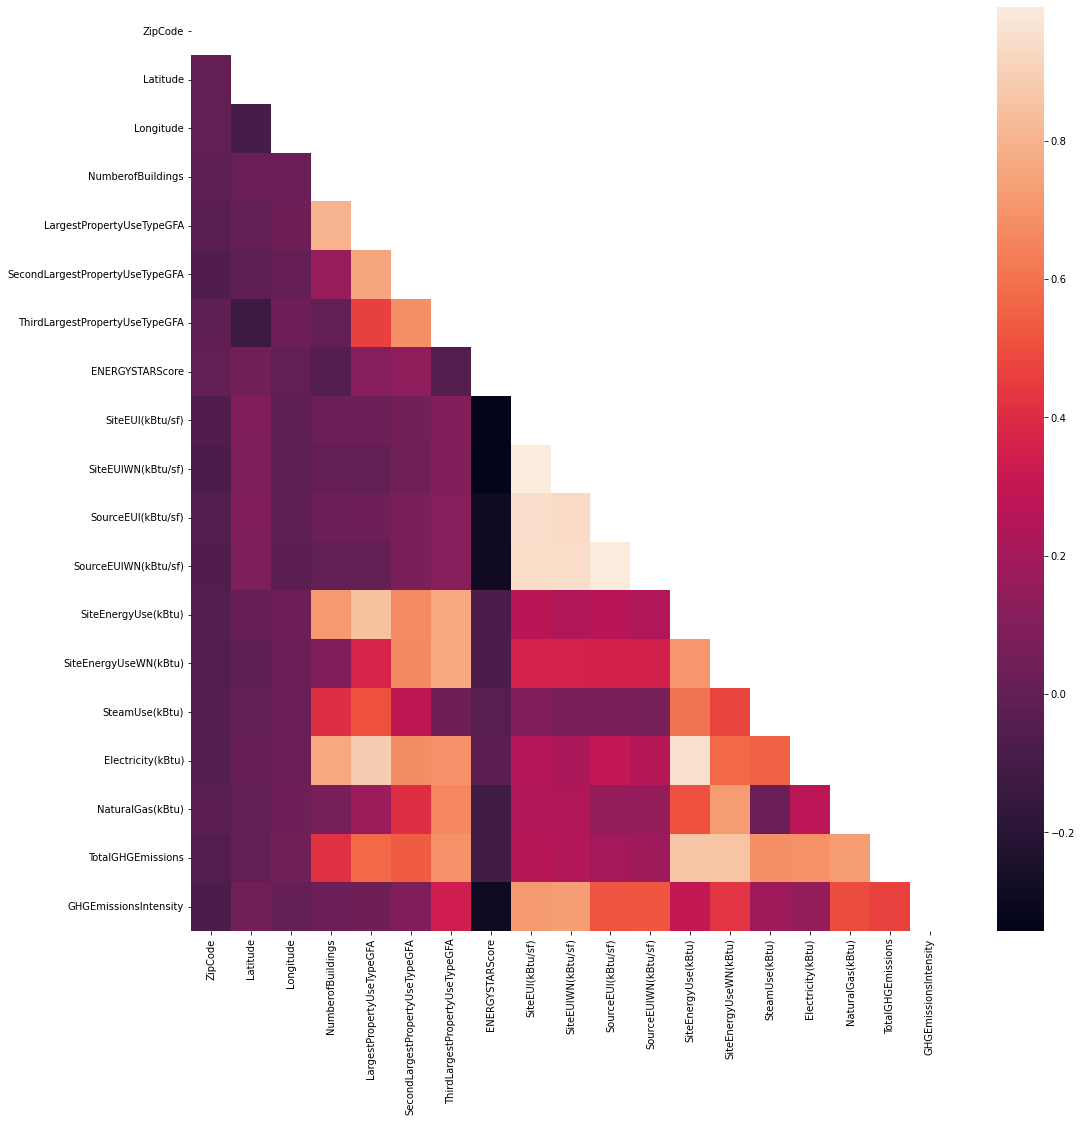

<Figure size 432x288 with 0 Axes>

In [12]:
#Looks like there's some colinear features let's do a corelation matrix
corr_mat = data_num.corr()

mask = np.triu(np.ones_like(corr_mat, dtype = bool))
fig, ax = plt.subplots(figsize = (17,17))
sns.heatmap(corr_mat, ax=ax, mask=mask)
plt.show()
plt.clf()

In [13]:
#identify the colinear features 
df_corr = {}
for i in corr_mat.columns:
    x = corr_mat.loc[(corr_mat[i] > 0.9) & (corr_mat[i] != 1)]
    if x.shape[0] != 0:
        df_corr[f'{i}'] = x.index

for i in df_corr:
    print(i, df_corr[i])

SiteEUI(kBtu/sf) Index(['SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'], dtype='object')
SiteEUIWN(kBtu/sf) Index(['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'], dtype='object')
SourceEUI(kBtu/sf) Index(['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'], dtype='object')
SourceEUIWN(kBtu/sf) Index(['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)'], dtype='object')
SiteEnergyUse(kBtu) Index(['Electricity(kBtu)'], dtype='object')
Electricity(kBtu) Index(['SiteEnergyUse(kBtu)'], dtype='object')


In [14]:
#SiteEnergyUse will be a target so will drop colinear feature with it and drop feature that brings no data
data = data.drop(labels = ['Electricity(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'], axis = 1)
data_num = data_num.drop(labels = ['Electricity(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'], axis = 1)

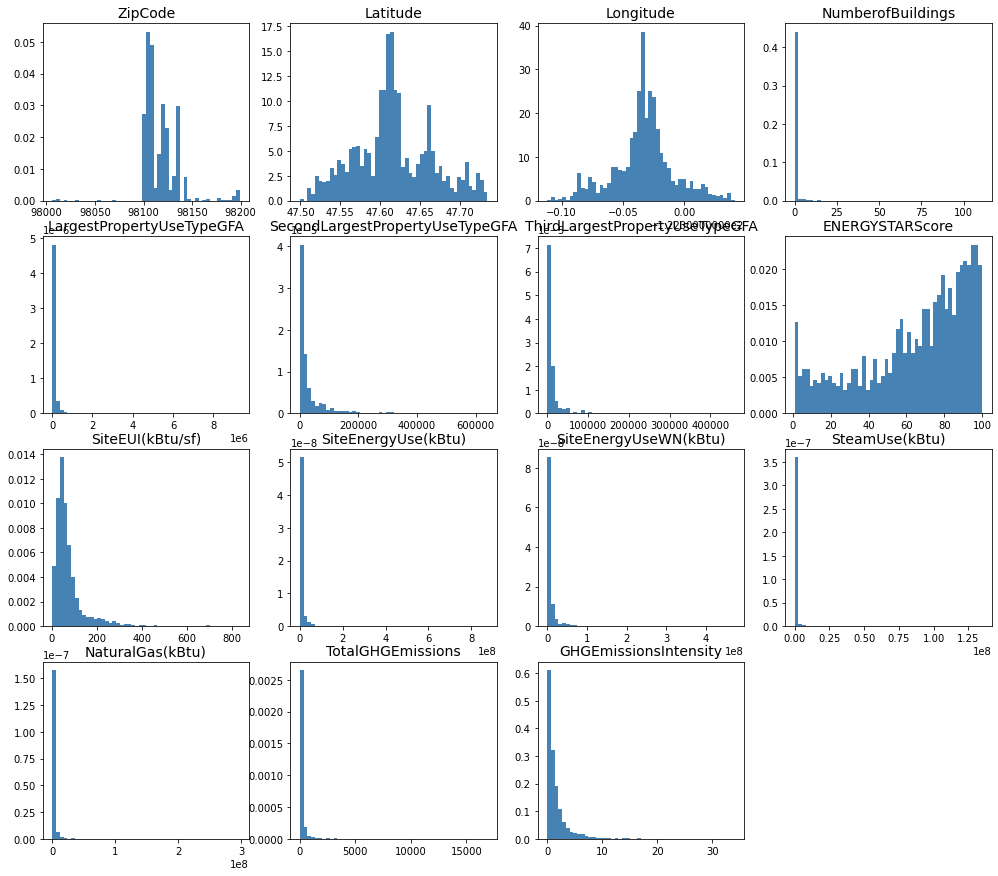

In [15]:
#let's see the distribution 
fig = plt.figure(figsize=(17, 15))
for i in range(data_num.shape[1]):
    ax = fig.add_subplot(4,4, (i+1))
    h = ax.hist(data_num.iloc[:, i], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data_num.columns[i], fontsize=14)


<AxesSubplot:>

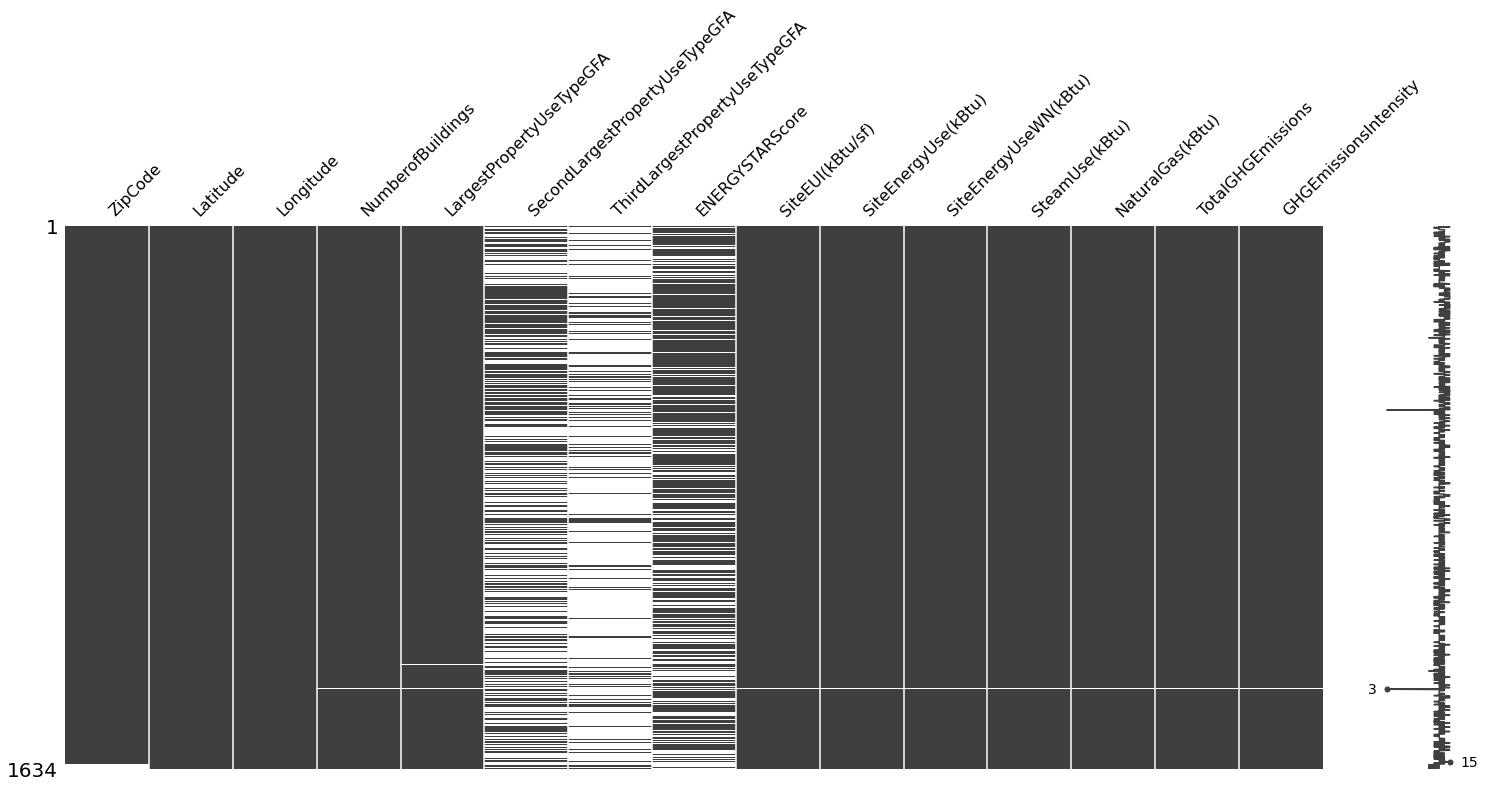

In [16]:
msno.matrix(data_num)

In [17]:
from sklearn.impute import KNNImputer


In [18]:
imputer = KNNImputer(n_neighbors = 5)
data_num_imput = imputer.fit_transform(data_num)

<AxesSubplot:>

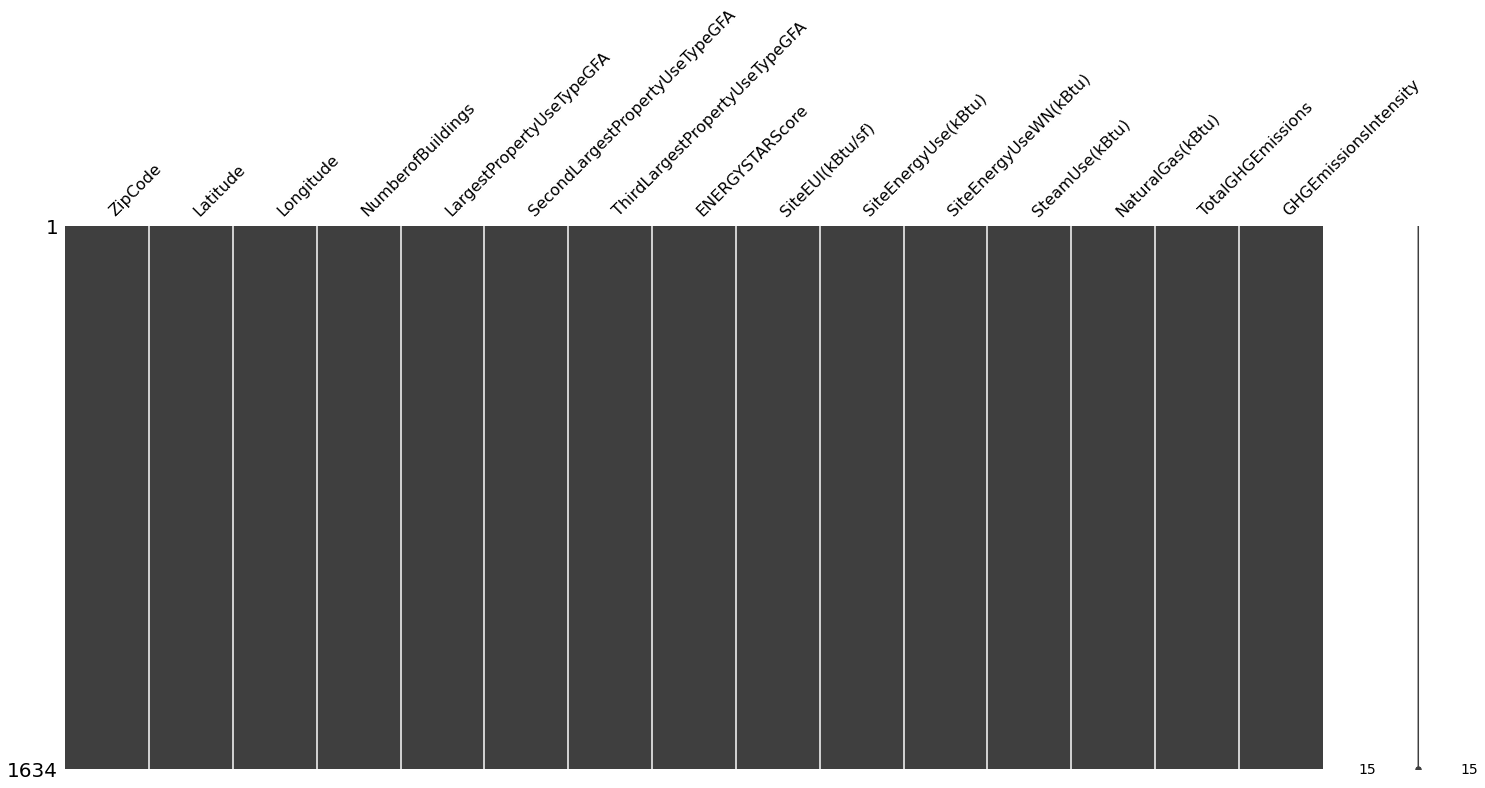

In [19]:
data_num_i = pd.DataFrame(data_num_imput, columns = data_num.columns, index = data_num.index)
msno.matrix(data_num_i)

In [20]:
#lest's try the first models with the data num at first
data_num_i.to_csv('data_num.csv', index = False)

### Données manquantes

### Nouveau jeu de données sans données relevées

In [39]:
#drop every row that is a 'futur' mesurement
data2 = data
mesure = ['SiteEnergyUseWN(kBtu)','SteamUse(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'Outlier', 'DefaultData', 'ComplianceStatus']
data2 = data2.drop(labels = mesure, axis = 1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 1 to 50226
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1634 non-null   object 
 1   PrimaryPropertyType              1634 non-null   object 
 2   ZipCode                          1618 non-null   float64
 3   CouncilDistrictCode              1634 non-null   int64  
 4   Neighborhood                     1634 non-null   object 
 5   Latitude                         1634 non-null   float64
 6   Longitude                        1634 non-null   float64
 7   YearBuilt                        1634 non-null   int64  
 8   NumberofBuildings                1632 non-null   float64
 9   NumberofFloors                   1634 non-null   int64  
 10  PropertyGFATotal                 1634 non-null   int64  
 11  PropertyGFAParking               1634 non-null   int64  
 12  PropertyGFABuilding

<AxesSubplot:>

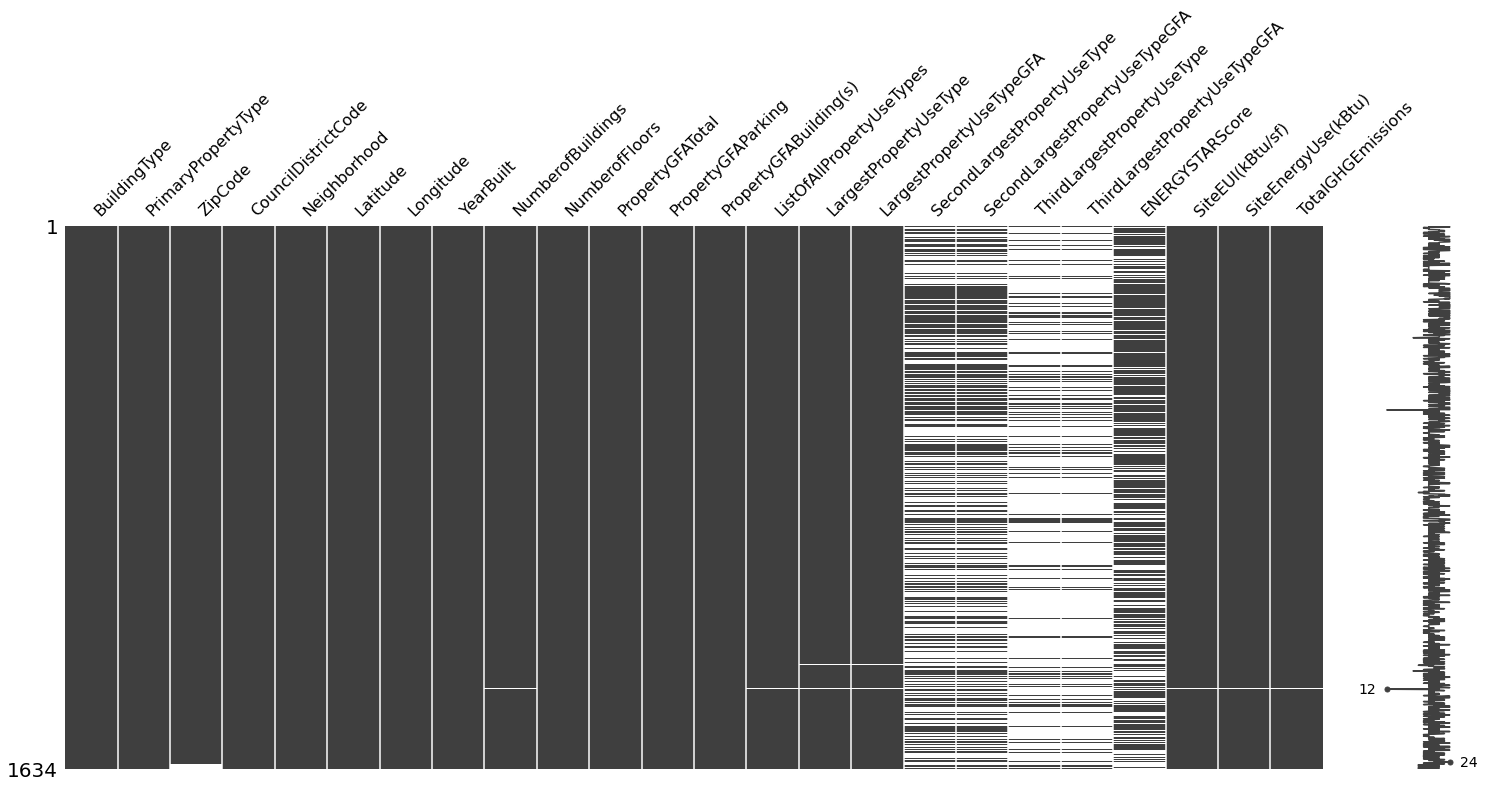

In [40]:
msno.matrix(data2)

In [41]:

num_col = []
for i in data2.columns:
    if data2[i].dtype =='float64' or data2[i].dtype =='int64':
        num_col.append(i)
data2_num = data2[num_col]
print(data2_num.columns)


Index(['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'],
      dtype='object')


In [42]:
data2_num_imput = imputer.fit_transform(data2_num)
data2_num_i = pd.DataFrame(data2_num_imput, columns = data2_num.columns, index = data2_num.index)

In [43]:
data2_num_i.to_csv('data2_num.csv', index = False)

### Binarize

In [44]:
not_num_col = []
for i in data2.columns:
    if data2[i].dtype != 'float64' and data2[i].dtype != 'int64':
        not_num_col.append(i)
data2_not_num = data2[not_num_col]

In [45]:
print(data2_not_num.columns)

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'],
      dtype='object')


In [28]:
#data2_not_num = data2_not_num.drop(labels = ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'], axis = 1)
#data2_not_num = data2_not_num.dropna(subset = ['LargestPropertyUseType'])

In [46]:
data2_not_num.head()

,BuildingType,PrimaryPropertyType,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
OSEBuildingID,,,,,,,
1,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,NaN,NaN
2,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant
3,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,NaN,NaN
5,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,NaN,NaN
8,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool


In [47]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse = False,drop = 'if_binary')

In [48]:
data2_not_num_ohe = OHE.fit_transform(data2_not_num)
data2_not_num_ohe = pd.DataFrame(data2_not_num_ohe, index = data2_not_num.index)
print(data2_not_num_ohe.shape)

    

(1634, 560)


In [49]:
#4197,4198,4200,4206,4207,4208,4209
data2_not_num_ohe.isna().sum().sum()

0

In [52]:
data_full = data2_not_num_ohe.join(data2_num_i)
print(data2_num_i.shape, data2_not_num_ohe.shape, data_full.shape)

(1634, 17) (1634, 560) (1634, 577)


In [53]:
data_full.to_csv('data_full.csv', index = False)